In [2]:
import pandas as pd
import os
import numpy as np
import logging
import sys
import torch
import copy
import yaml
import random

from prediction_utils.pytorch_utils.metrics import (
    StandardEvaluator,
    FairOVAEvaluator,
    CalibrationEvaluator
)

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set_style("ticks")



EXPERIMENT_NAME = 'apr14_thr'
include_recalibrated = False
args = {'experiment_name': EXPERIMENT_NAME,
        'cohort_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts/cohort/all_cohorts.csv',
        'base_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts',
        'plot_path': os.path.join('/labs/shahlab/projects/agataf/fairness_utility/eval/plots', EXPERIMENT_NAME)
       }
eval_fold = 'eval'

aggregate_path = os.path.join(args['base_path'], 'experiments', 
                              EXPERIMENT_NAME, 'performance',
                              'all')
if include_recalibrated == True:
    preds_path = os.path.join(aggregate_path, 'predictions_test_recalibrated.csv')
else:
    preds_path = os.path.join(aggregate_path, 'predictions.csv')
    
preds = pd.read_csv(preds_path)
preds_eval = preds.query("phase=='eval'")
preds_test = preds.query("phase=='test'")

experiment_plot_path = args['plot_path']
#os.makedirs(experiment_plot_path, exist_ok = True)





In [5]:
#recalib_experiment_name = 'apr14_erm'
#recalib_aggregate_path = os.path.join(args['base_path'], 'experiments', 
                             # recalib_experiment_name, 'performance',
                             # 'all')
#recalib_preds_path = os.path.join(recalib_aggregate_path, 'predictions_test_recalibrated.csv')
#recalib_preds = pd.read_csv(recalib_preds_path)
#recalib_preds = recalib_preds.assign(lambda_reg = lambda x: x.calibrated.map({False: 'erm', True: 'recalib'}))



In [ ]:
#preds = preds.append(recalib_preds)


In [6]:
set(preds_test.person_id.unique())==set(preds_eval.person_id.unique())

False

In [7]:
fair_evaluator = FairOVAEvaluator()
standard_evaluator = StandardEvaluator(metrics = ['ace_rmse_logistic_log', 'ace_abs_logistic_log'],
                              threshold_metrics = ['specificity', 'recall'],
                              thresholds = [0.075, 0.2])
violation_type = "EMD"

evals = []

for fold_id in range(1,11):
    for phase in ['test', eval_fold]:
        for lambda_reg in preds.query('phase==@phase').lambda_reg.unique():
            grp_df = preds.query("(lambda_reg==@lambda_reg) & (fold_id==@fold_id) & (phase==@phase)")


            if violation_type == 'EMD':
                standard_eval = fair_evaluator.get_result_df(df = grp_df, 
                                                    weight_var = 'weights'
                                                   )
                eqodds_viol = (standard_eval
                               .query("(metric=='emd_0_ova') | \
                                       (metric=='emd_1_ova') ")
                               .performance
                               .mean()
                              )            
            elif violation_type == 'threshold':
                standard_eval = standard_evaluator.get_result_df(df = grp_df, 
                                                    weight_var = 'weights'
                                                   )
                               
                eqodds_viol = (standard_eval
                               .query("(metric=='recall_0.075') | \
                                       (metric=='recall_0.2') | \
                                       (metric=='specificity_0.075') |\
                                       (metric=='specificity_0.2')")
                               .assign(diff_sq = lambda x: (x.performance-x.performance_overall)**2)
                               .diff_sq
                               .mean()
                              )  
            
            standard_eval = standard_eval.assign(
                fold_id = fold_id,
                lambda_reg = str(lambda_reg),
                phase = phase,
                eqodds_violation = eqodds_viol

            )
            
            evals.append(standard_eval)
            
evals_final = pd.concat(evals) 
evals_final = evals_final.assign(lambda_reg = lambda x: pd.Categorical(x.lambda_reg, 
                                                                       categories = list(x.lambda_reg.unique()),
                                                                       ordered = True)
                                )



fairness_violations_ova = (evals_final.filter(['fold_id', 
                                          'lambda_reg', 
                                          'phase', 
                                           'eqodds_violation']
                                         ).drop_duplicates()
                      )
                       

AttributeError: 'DataFrame' object has no attribute 'lambda_reg'

In [ ]:
evaluator = CalibrationEvaluator()

calibs = []

for fold_id in range(1,11):
    for phase in ['test', eval_fold]:
        for lambda_reg in preds.query('phase==@phase').lambda_reg.unique():
            grp_df = preds.query("(lambda_reg==@lambda_reg) & (fold_id==@fold_id) & (phase==@phase)")
            standard_eval = evaluator.relative_calibration_error(
                    labels = grp_df.labels,
                    pred_probs = grp_df.pred_probs,
                    sample_weight = grp_df.weights,
                    group = grp_df.group,
                    metric_variant="abs",
                    model_type="logistic",
                    transform='log')['result']
            
            
            standard_eval = standard_eval.assign(fold_id = fold_id,
                                                 lambda_reg = str(lambda_reg),
                                                 phase = phase,
                                                 mean_relative_calibration_error = lambda x: x.relative_calibration_error.mean()
                                                #group = group
                                                )


            calibs.append(standard_eval)
            
calibs_by_group = (pd.concat(calibs)
                   .reset_index(drop=True)            
                   .assign(lambda_reg = lambda x: pd.Categorical(x.lambda_reg, 
                                                                 categories = list(x.lambda_reg.unique()),
                                                                 ordered = True)
                          )
                  )


rel_calibration_violations = (calibs_by_group.filter(['fold_id',
                                                      'lambda_reg', 
                                                      'phase', 
                                                      'mean_relative_calibration_error']
                                                    )
                              .drop_duplicates()
                             )


In [ ]:
def is_pareto_efficient_simple(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

In [ ]:
costs_eval

In [8]:
tradeoffs = rel_calibration_violations.merge(fairness_violations_ova, on=['fold_id', 'lambda_reg', 'phase'])
tradeoffs = tradeoffs.sort_values(by=['lambda_reg', 'fold_id'])
tradeoffs_eval = tradeoffs.query('phase==@eval_fold').reset_index(drop=True)
tradeoffs_test = tradeoffs.query('(phase=="test") & (lambda_reg!="erm") & (lambda_reg!="recalib")').reset_index(drop=True)

tradeoffs_test_all = tradeoffs.query('phase=="test"').reset_index(drop=True)

costs_eval = np.array(tradeoffs_eval.filter(['mean_relative_calibration_error', 'eqodds_violation']))
costs_test = np.array(tradeoffs_test.filter(['mean_relative_calibration_error', 'eqodds_violation']))

is_efficient = is_pareto_efficient_simple(costs_eval)
index_test = np.argsort(costs_test[is_efficient][:,0])
frontier_test = costs_test[is_efficient][index_test]
    
index_eval = np.argsort(costs_eval[is_efficient][:,0])
frontier_eval = costs_eval[is_efficient][index_eval]

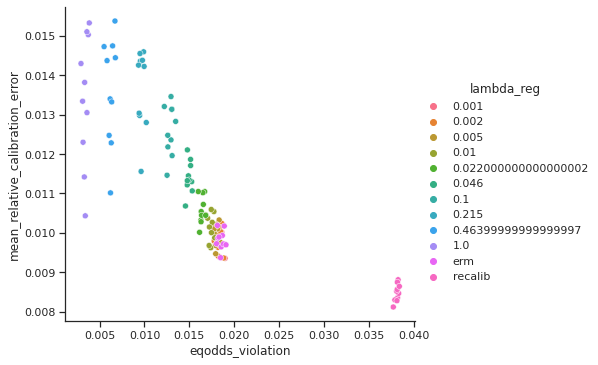

In [13]:
output_path = os.path.join(experiment_plot_path, 'calib_eqodd_tradeoff_test.png')

g = sns.relplot(data = tradeoffs_test_all,
                x = 'eqodds_violation',
                y = 'mean_relative_calibration_error',
                kind = 'scatter',
                hue = 'lambda_reg',
                legend = True,
                #ci='sd',
                aspect = 1.2,
               )
# g.axes[0,0].plot(frontier_test[:,1],
#                  frontier_test[:,0],
#                   #marker="o"
#                 )

if output_path is not None:
    g.savefig(output_path)

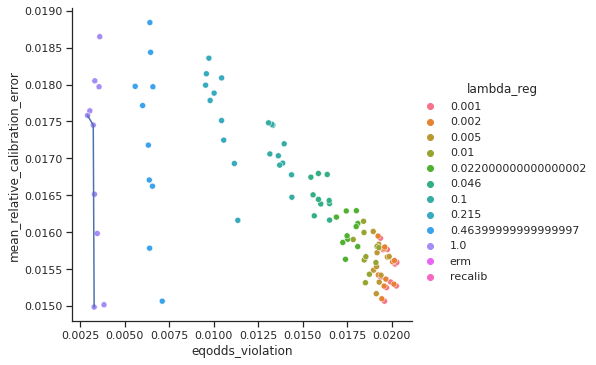

In [10]:
output_path = os.path.join(experiment_plot_path, 'calib_eqodd_tradeoff_eval.png')

g = sns.relplot(data = tradeoffs_eval,
                x = 'eqodds_violation',
                y = 'mean_relative_calibration_error',
                kind = 'scatter',
                hue = 'lambda_reg',
                legend = True,
                #ci='sd',
                aspect = 1.2,
               )
g.axes[0,0].plot(frontier_eval[:,1],
                 frontier_eval[:,0],
                  #marker="o"
                )

if output_path is not None:
    g.savefig(output_path)

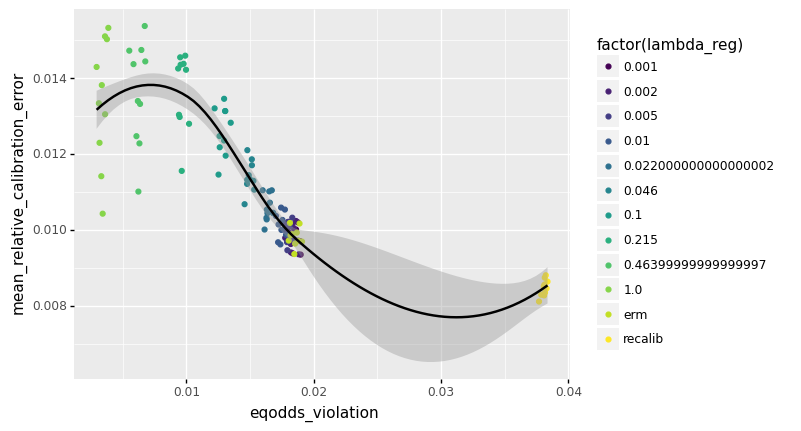

<ggplot: (8754923612121)>

In [11]:
from plotnine.stats import stat_smooth
from plotnine import *

(ggplot(tradeoffs.query("phase=='test'"), aes(x='eqodds_violation', y='mean_relative_calibration_error', ) )
 + geom_point(aes(color='factor(lambda_reg)'))
 + stat_smooth(geom='smooth', position='identity',
            na_rm=False, n=80, formula=None, se=True, span=0.75,
           )
)

# (ggplot(tradeoffs.query("phase=='eval'"), aes(x='eqodds_violation', y='mean_relative_calibration_error', ) )
#  + geom_point(aes(color='factor(lambda_reg)'))
#  + stat_smooth(geom='smooth', position='identity',
#             na_rm=False, n=80, formula=None, se=True, span=.8,
#            )
# )

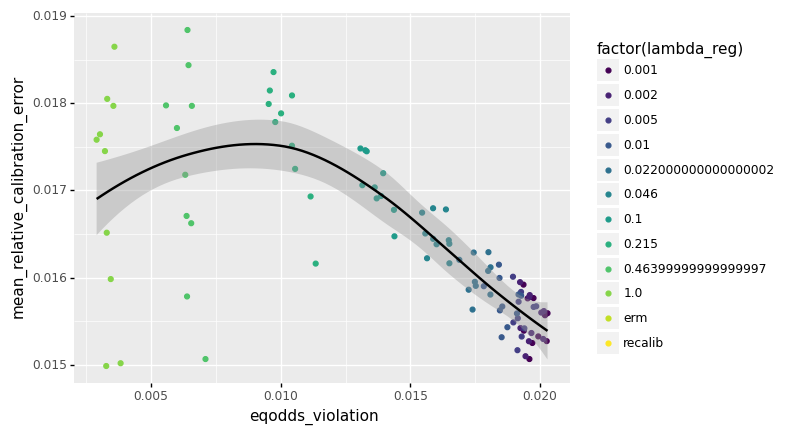

<ggplot: (8754885004785)>

In [12]:
from plotnine.stats import stat_smooth
from plotnine import *

(ggplot(tradeoffs.query("phase=='eval'"), aes(x='eqodds_violation', y='mean_relative_calibration_error', ) )
 + geom_point(aes(color='factor(lambda_reg)'))
 + stat_smooth(geom='smooth', position='identity',
            na_rm=False, n=80, formula=None, se=True, span=0.75,
           )
)

# (ggplot(tradeoffs.query("phase=='eval'"), aes(x='eqodds_violation', y='mean_relative_calibration_error', ) )
#  + geom_point(aes(color='factor(lambda_reg)'))
#  + stat_smooth(geom='smooth', position='identity',
#             na_rm=False, n=80, formula=None, se=True, span=.8,
#            )
# )